# Regression on RBS sequences - Escherichia coli - Predict FC

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - RMSE score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

In [5]:
df['RBS'] = df['rbs1'] + df['rbs2']

# take log FC -- possiblely provide Gaussain distribution?
if Log_flag:
    df['FC'] = np.log(df['FC'])

if Norm_method == 'mean':
    # mean normalization
    df['FC'] = (df['FC'] - df['FC'].mean())/df['FC'].std()
elif Norm_method == 'minmax':
    # min-max normalization 
    df['FC'] = (df['FC'] - df['FC'].min())/(df['FC'].max() - df['FC'].min())
else:
    assert Norm_method == None

data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

## Regression

- Kernel Ridge Regression
- Gaussian Process Regression


In [6]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               mixed_spectrum_kernel_pw: 'mspec',
               WD_kernel_pw: 'WD',
               WD_shift_kernel_pw: 'WDshift'}

train_scores = {}
test_scores = {}

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.1582002813118842
Test RMSE:  0.14212472229226839


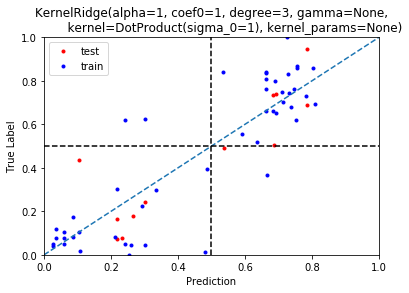

In [7]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_onehot_DP'] = train_score
test_scores['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=RBF(length_scale=1.4), kernel_params=None)
Train RMSE:  0.14636691228873822
Test RMSE:  0.18043439974223544


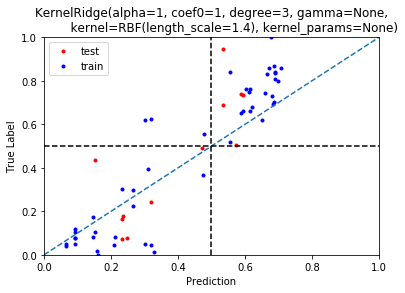

In [8]:
reg = Regression(KernelRidge(kernel = RBF(1.4)), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_onehot_RBF'] = train_score
test_scores['KR_onehot_RBF'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.15249592123761088
Test RMSE:  0.15850974175363872


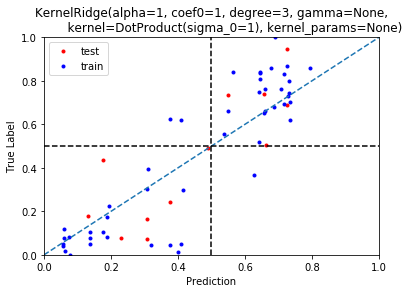

In [9]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_kmer_DP'] = train_score
test_scores['KR_kmer_DP'] = test_score

### Gaussian Process Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.15776064508621568
Test RMSE:  0.14340410170580922


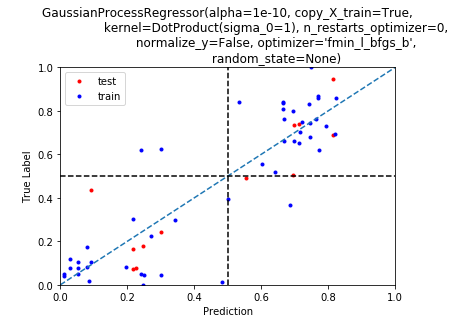

In [10]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_onehot_DP'] = train_score
test_scores['GPR_onehot_DP'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1.4), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.08453424302898578
Test RMSE:  0.18865444519971622


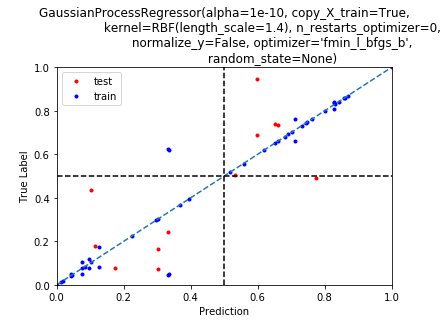

In [11]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = RBF(1.4)), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_onehot_RBF'] = train_score
test_scores['GPR_onehot_RBF'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.1393948648122613
Test RMSE:  0.152471476072097


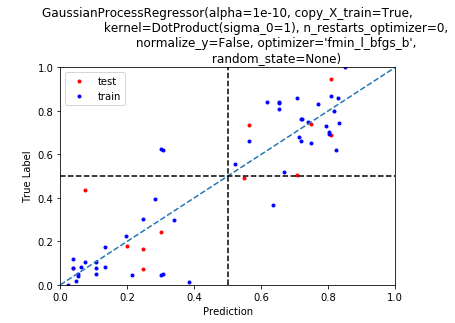

In [12]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_kmer_DP'] = train_score
test_scores['GPR_kmer_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7fb0c25e4378>,
            kernel_params=None)
Train RMSE:  0.15310396691110154
Test RMSE:  0.157971276192602

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7fb0c25e4400>,
            kernel_params=None)
Train RMSE:  0.16891370122090354
Test RMSE:  0.20524397467577346

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7fb0c25e4488>,
            kernel_params=None)
Train RMSE:  0.13295322145320695
Test RMSE:  0.1533240867976811

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_shift_kernel_pw at 0x7fb0c25e4510>,
            kernel_params=None)
Train RMSE:  0.1320953427029725
Test RMSE:  0.1546073319668593

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Pair

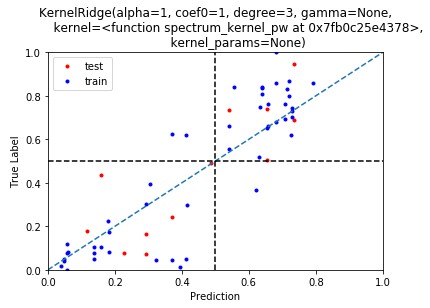

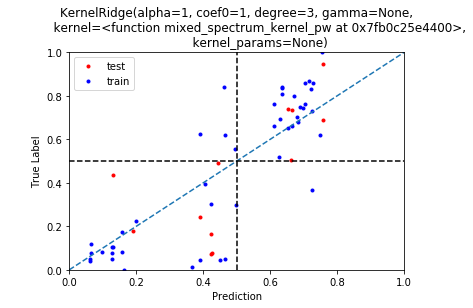

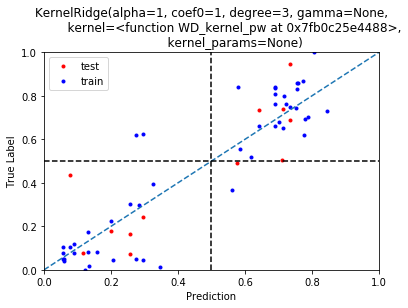

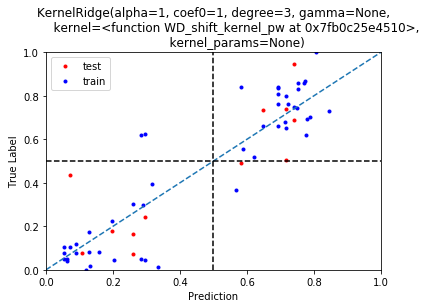

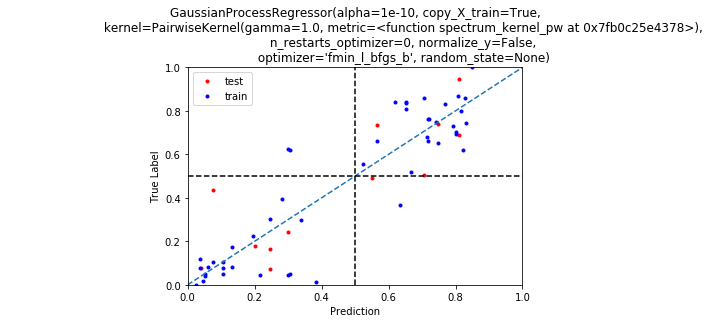

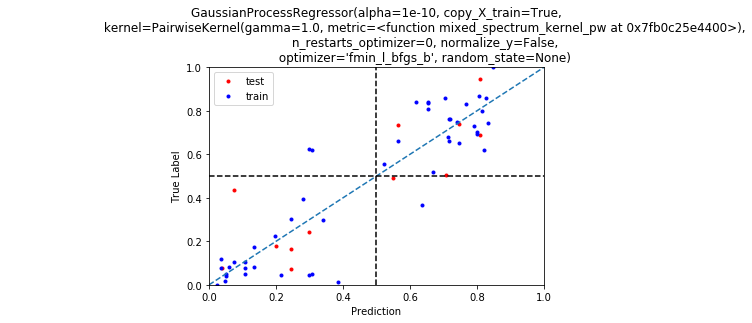

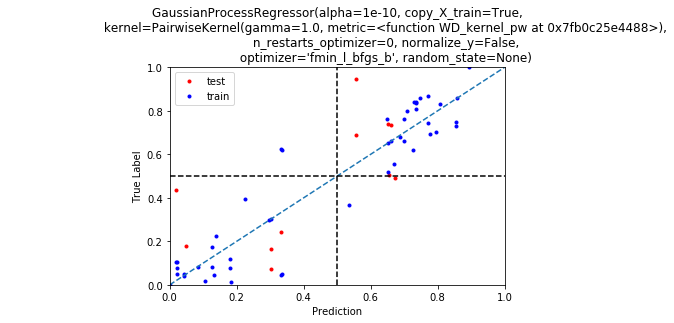

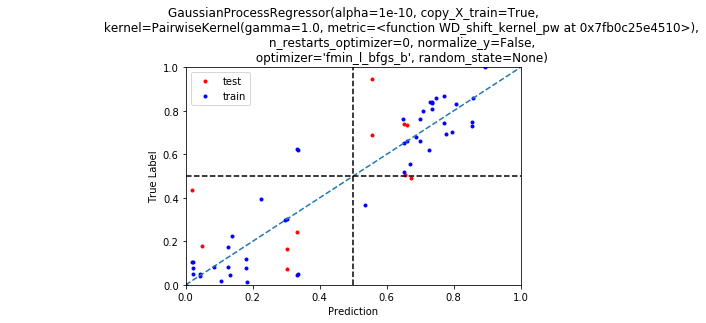

In [13]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

Text(0.5, 1.0, 'Train Scores')

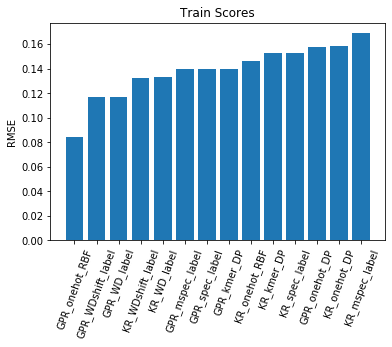

In [14]:
sorted_train_scores = sorted(train_scores.items(), key=lambda kv: kv[1])

import collections

sorted_train_scores = collections.OrderedDict(sorted_train_scores)

plt.bar(range(len(sorted_train_scores)), list(sorted_train_scores.values()), align='center')
plt.xticks(range(len(sorted_train_scores)), list(sorted_train_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Train Scores')

Text(0.5, 1.0, 'Test Scores')

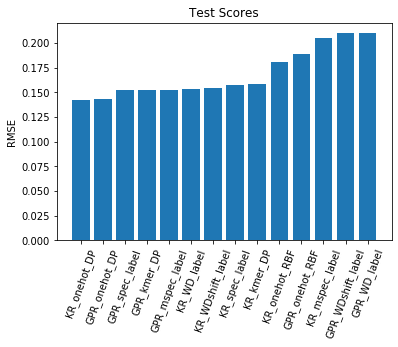

In [15]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')